# SAN Assignment - Linear discriminant analysis

Author : Your Name

Email  : you@fel.cvut.cz

## Introduction
The aim of this assignment is to get familiar with Linear Discriminant Analysis
(LDA). LDA and Principal Component Analysis (PCA) are two techniques
for dimensionality reduction. PCA can be described as an unsupervised algorithm that ignores data labels and aims to find directions which maximalize
the variance in a data. In comparison with PCA, LDA is a supervised algorithm and aims to project a dataset onto a lower dimensional space with good
class separability. In other words, LDA maximalizes the ratio of betweenclass variance and the within-class variance in a given data.

Your task is to complete prepared LDA implementation and inspect the mehods behavior. 
See **all** sections with `# TODO:`. 
Submit your solution consisting of both this modified notebook file and the exported PDF/HTML document as an archive to the courseware BRUTE upload system for the SAN course.
The deadline is specified there. 

## Input data 
In this tutorial, we will work with a dataset that classifies wines (samples)
into three classes using of 13 continuous attributes; for more details see
wine info.txt file. The dataset is located at wine.csv.

## Linear Discriminant Analysis
As we mentioned above, LDA finds directions where classes are well-separated,
i.e. LDA maximizes the ratio of between-class variance and the within-class
variance. Firstly, assume that $C$ is a set of classes and set $D$, which represents
a training dataset, is defined as $D = \{x_1, x_2, . . . , x_N \}$.

The between-classes scatter matrix SB is defined as:
$S_b = \sum_c N_C(\mu_c -\overline{x})(\mu_c - \overline{x})^T$, where $\overline{x}$ is a vector represents the overall mean of the data, µ represents the mean corresponding to each class, and $N_C$ are sizes of the respective classes.

The within-classes scatter matrix $S_W$ is defined as:

$S_W = \sum_c \sum_{x \in D_c}(x - \overline{\mu_c})(x - \overline{\mu_c})^T$

Next, we will solve the generalized eigenvalue problem for the matrix $S_W^{-1}S_B$ to obtain the linear discriminants, i.e.

$(S_W^{-1}S_B)w = \lambda w$

where $w$ represents an eigenvector and $\lambda$ represents an eigenvalue. Finally,
choose k eigenvectors with the largest eigenvalue and transform the samples
onto the new subspace.


### imports

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

## Step by step

In this assignment, you first finish the given LDA implementation and then compare it with PCA (for a classification task).


### LDA Implementation

##### Compute the within-scatter matrix

In [54]:
def compute_within_scatter(data):
    """ Function to compute within scatter matrix S_w.

    :param data: list of numpy arrays with data from individual classes
    """
    
    n_features = data[0].shape[1]
    within_matrix = np.zeros((n_features, n_features))

    for X in data:
        # Compute mean of each feature
        mu = np.mean(X, axis=0)
        # Substract mean from data
        X_centered = X - mu
        # Compute within matrix for specific class
        class_within_matrix = X_centered.T @ X_centered
        # Iteratively sum the within matrices for each class
        within_matrix += class_within_matrix 

    return within_matrix

##### Compute the between-scatter matrix

In [55]:
def compute_global_mean(data):
    global_mu = 0
    total_samples = 0
    for X in data:
        n_samples = X.shape[0]
        mu = np.mean(X, axis=0)
        global_mu += n_samples * mu
        total_samples += n_samples
    global_mu = global_mu / total_samples
    return global_mu

def compute_between_scatter(data):
    """ Function to compute between scatter matrix S_b.

    :param data: list of numpy arrays with data from individual classes
    """
    n_classes = len(data)
    n_features = data[0].shape[1]
    between_matrix = np.zeros((n_features, n_features))

    global_mu = compute_global_mean(data)
    
    for X in data:
        n_samples = X.shape[0]
        mu = np.mean(X, axis=0)
        diff = (mu - global_mu).reshape(-1, 1)
        between_matrix += n_samples * (diff @ diff.T)

    return between_matrix

##### Solve the EigenProblem and return eigen-vector

In [61]:
def solve_eigen_problem(within_matrix, between_matrix):
    """ Compute eigenvectors as defined by the method.

    :param within_matrix: numpy array (n_variables, n_variables)
    :param between_matrix: numpy array, same shape
    :return: real eigenvectors, ordered from the highest eigenvalue, numpy array, (n_variables,n)
    """

    within_matrix_inverse = np.linalg.inv(within_matrix) 
    
    eigenvalues , eigenvectors = np.linalg.eig(within_matrix_inverse @ between_matrix)

    # Sort indeces of eigenvalues and then reverse them
    eigenval_idx_sorted = np.argsort(eigenvalues)[::-1]    

    # Sort eigenvectors
    eigenvectors_sorted = eigenvectors[:, eigenval_idx_sorted]

    eigenvectors_sorted = np.real(eigenvectors_sorted)

    return eigenvectors_sorted

##### Visualize the results
Project your data into lower-dimensional subspace, visualize this projection, and compare with PCA (see Fig. 1). Use the following code while filling in the lines marked as `TODO`.

In [57]:
def split_by_class(data, labels):
    ret = []
    # np.unique(labels) = [1, 2, 3]
    for lbl in np.unique(labels):
        ret.append(data[labels == lbl])
    return ret


def compute_centroids(data, labels):
    ret = []
    for lbl in np.unique(labels):
        ret.append(data[labels == lbl].mean(axis=0))
    return np.array(ret)


def classify(data, eigen_vectors, centroids, prior):
    n_classes = len(centroids)

    y = data @ eigen_vectors[:, :n_classes]
    classif = np.empty((data.shape[0], n_classes))
    for c in range(n_classes):
        classif[:, c] = ((y - centroids[c]) ** 2 / 2).sum(axis=1) - np.log(prior[c])
    return classif.argmin(axis=1) + 1  # indexes start 0, labels start as 1


In [58]:
def LDA(data, labels, plot_title=None):
    data_per_class = split_by_class(data, labels)

    # 1) scatter matrices
    # within-class scatter matrix Sw
    S_w = compute_within_scatter(data_per_class)

    # between-class scatter matrix Sb
    S_b = compute_between_scatter(data_per_class)

    # 2)  eigen problem
    # solve eigen problem
    eigenvectors = solve_eigen_problem(S_w, S_b)
    # print("Eigenvectors: ", eigenvectors)

    #transform the samples onto the new subspace
    y = data @ eigenvectors[:, :2]

    ## visual comparison with PCA
    scaled_data = StandardScaler().fit_transform(data)
    y_pca = PCA(2).fit_transform(data)
    y_pca_scaled = PCA(2).fit_transform(scaled_data)

    fig, axs = plt.subplots(ncols=3, figsize=(12, 6))
    axs[0].scatter(y[:, 0], y[:, 1], c=labels)
    axs[0].set_xlabel("LDA_1")
    axs[0].set_ylabel("LDA_2")
    axs[0].set_title("LDA")

    axs[1].scatter(y_pca[:, 0], y_pca[:, 1], c=labels)
    axs[1].set_xlabel("PCA_1")
    axs[1].set_ylabel("PCA_2")
    axs[1].set_title("PCA not scaled")

    axs[2].scatter(y_pca_scaled[:, 0], y_pca_scaled[:, 1], c=labels)
    axs[2].set_xlabel("PCA_1")
    axs[2].set_ylabel("PCA_2")
    axs[2].set_title("PCA scaled")

    if plot_title is not None:
        fig.suptitle(plot_title)

    fig.tight_layout()
    # fig.show()  # in non-interactive fashion, this gives non-useful warning

    return eigenvectors


In [59]:
def crossvalidation_lda(data, labels, n_folds=10):
    seed = 0
    n_classes = len(np.unique(labels))
    accuracy = []
    skf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    for i, (train_idxs, test_idxs) in enumerate(skf.split(data, labels)):
        eigen_lda = LDA(data[train_idxs], labels[train_idxs], plot_title=f"CV Split {i}")
        projected_data = data[train_idxs] @ eigen_lda[:, :n_classes]
        centroids = compute_centroids(projected_data, labels[train_idxs])
        predicted_labels = classify(data[test_idxs], eigen_lda, centroids,
                                    np.full(n_classes, 1. / n_classes))
        accuracy.append(np.mean(predicted_labels == labels[test_idxs]))
    return np.mean(accuracy)

### Run your LDA implementation

accuracy: 1.0
Cross validation mean:  0.9722222222222221


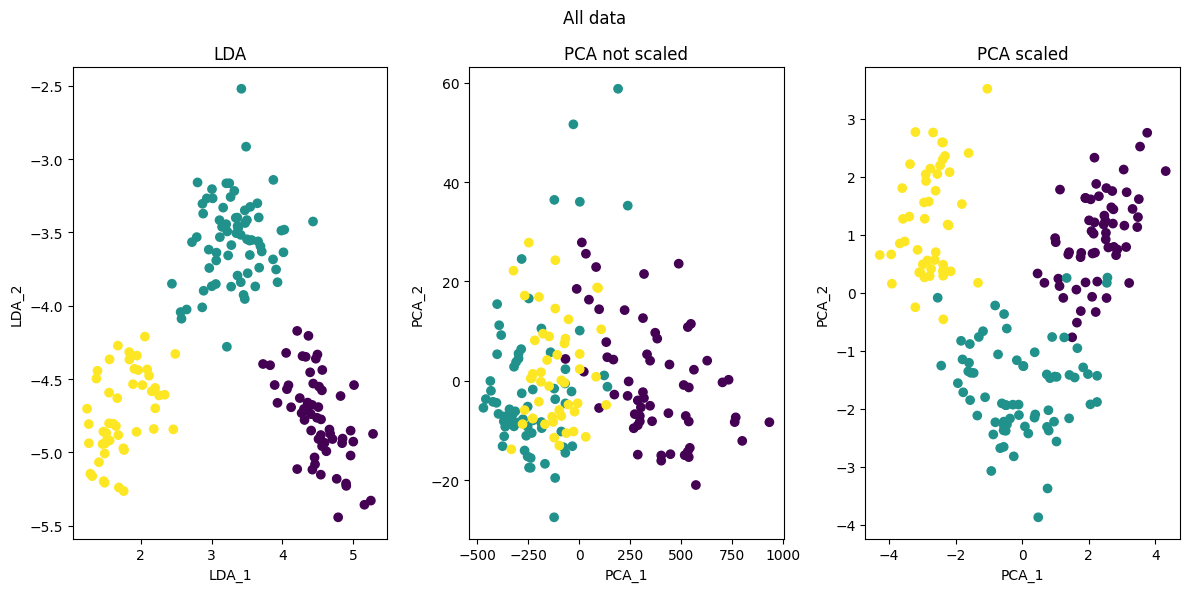

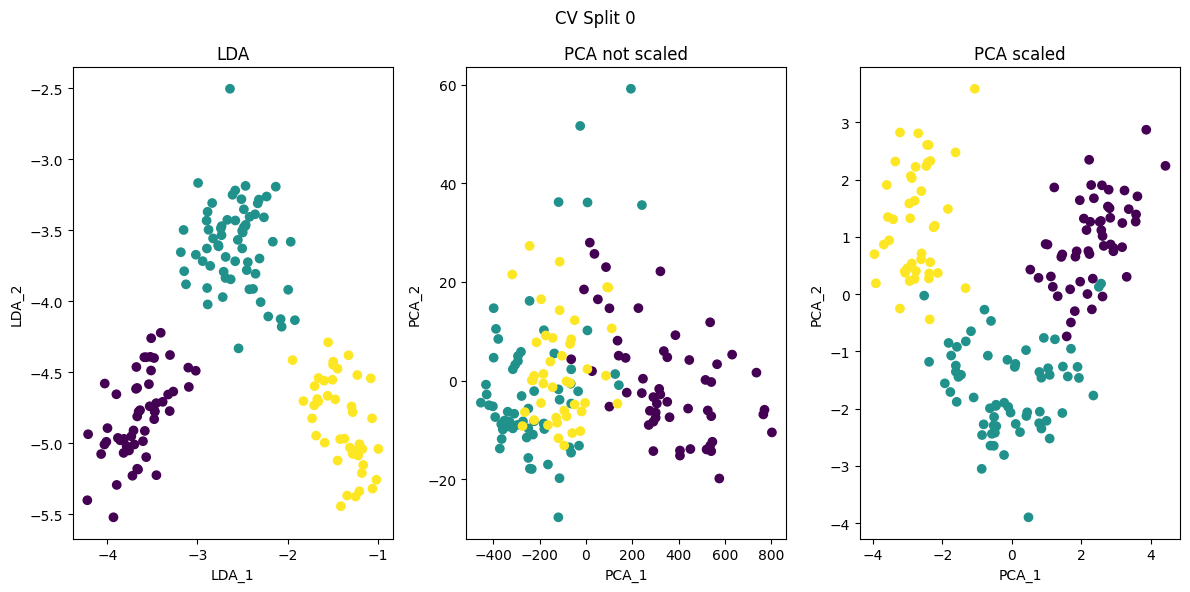

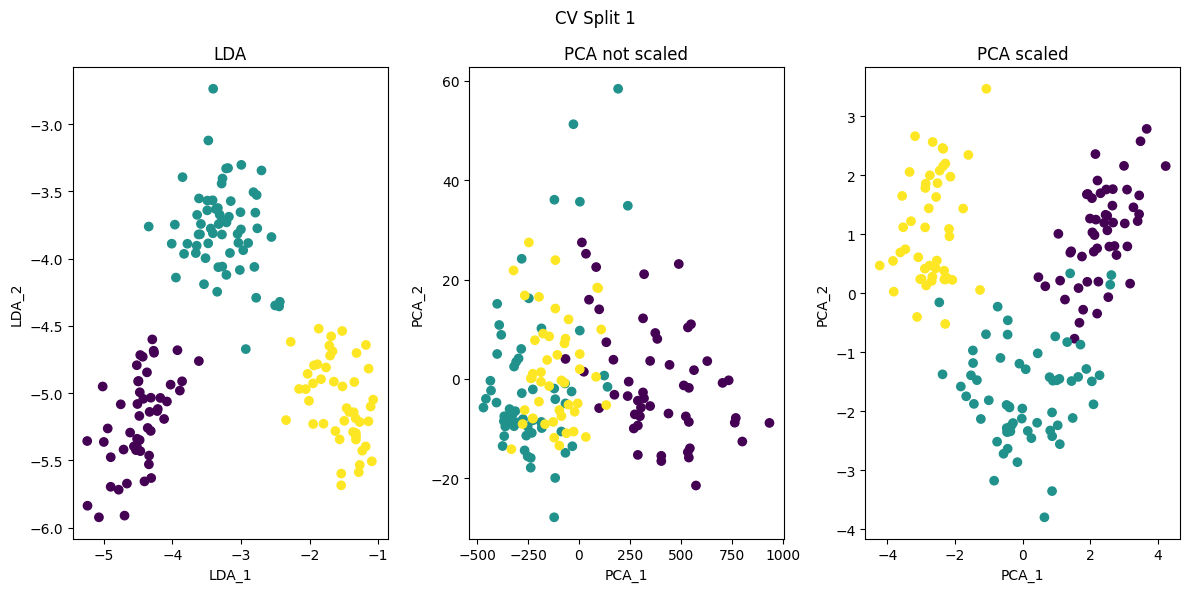

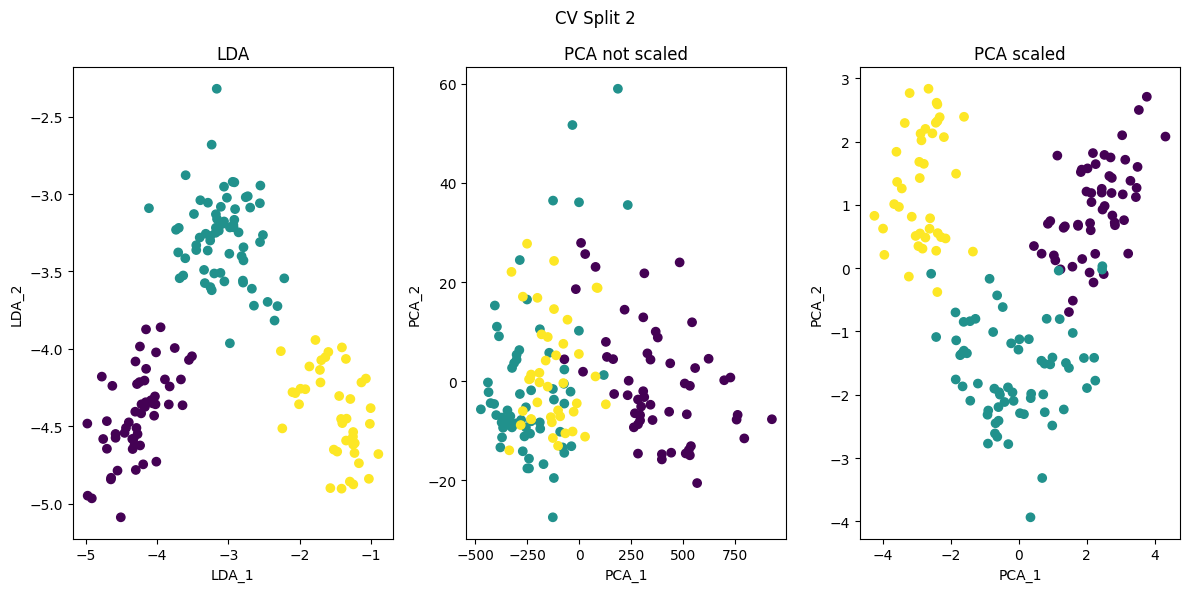

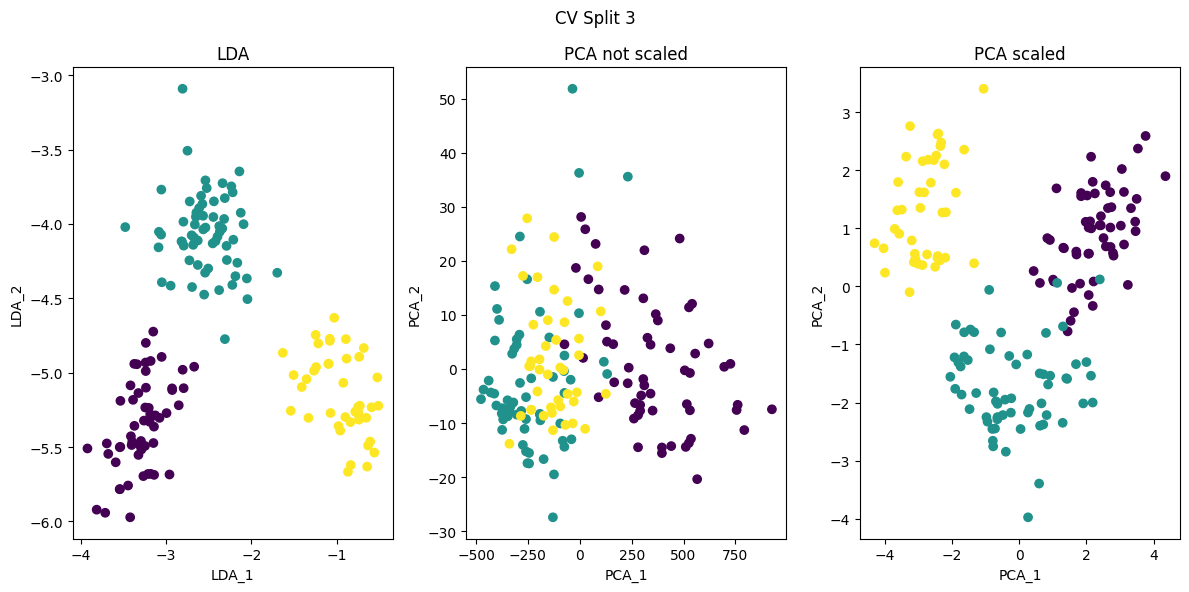

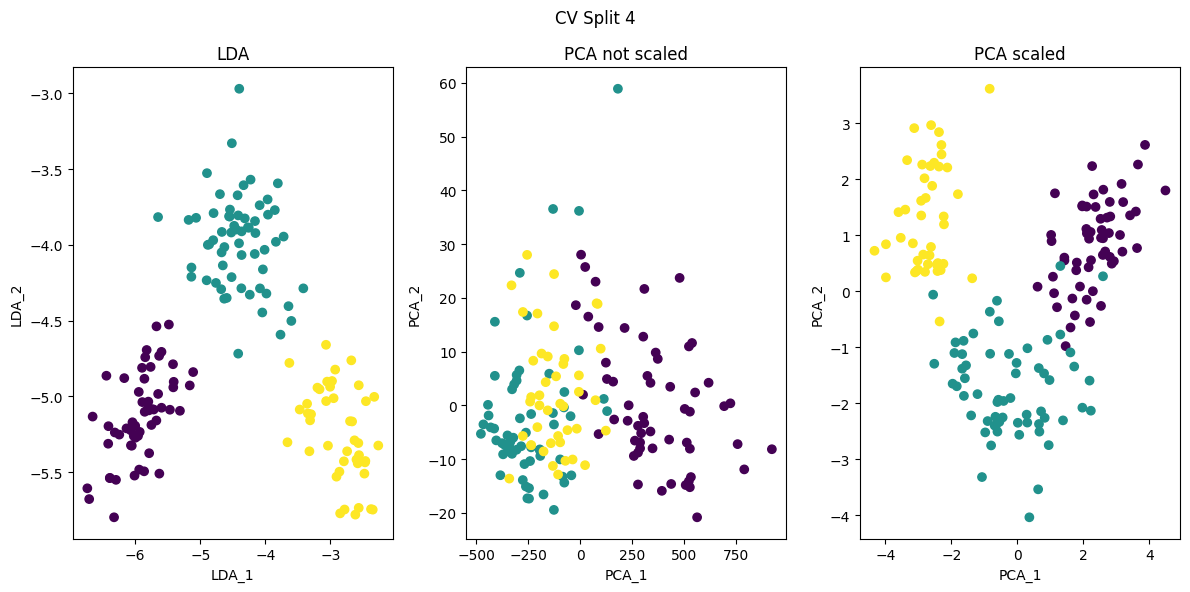

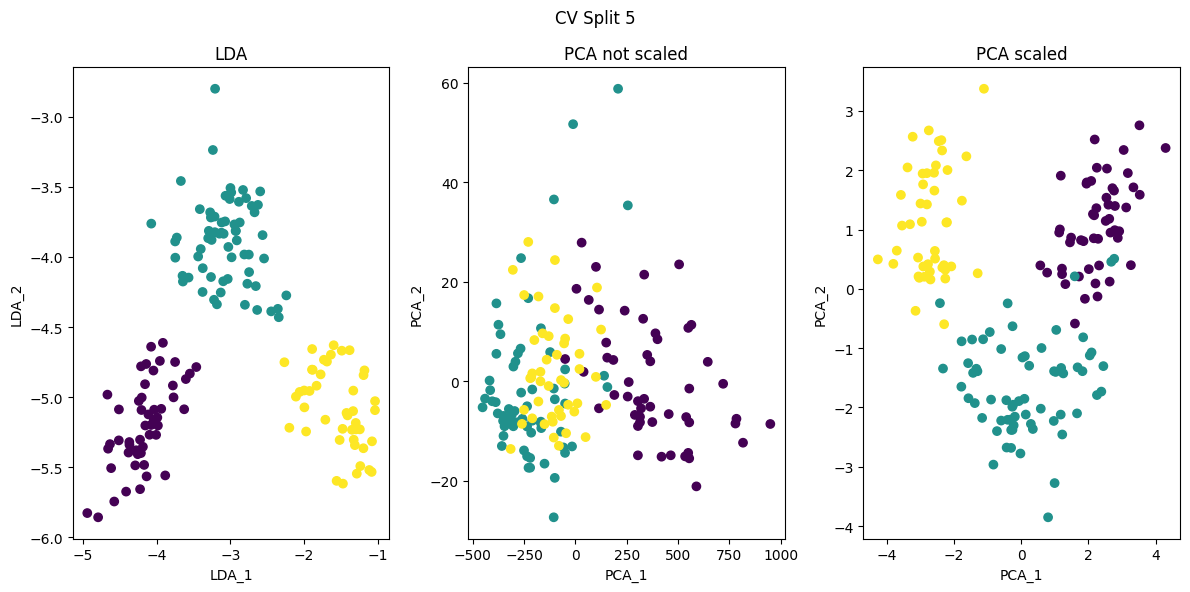

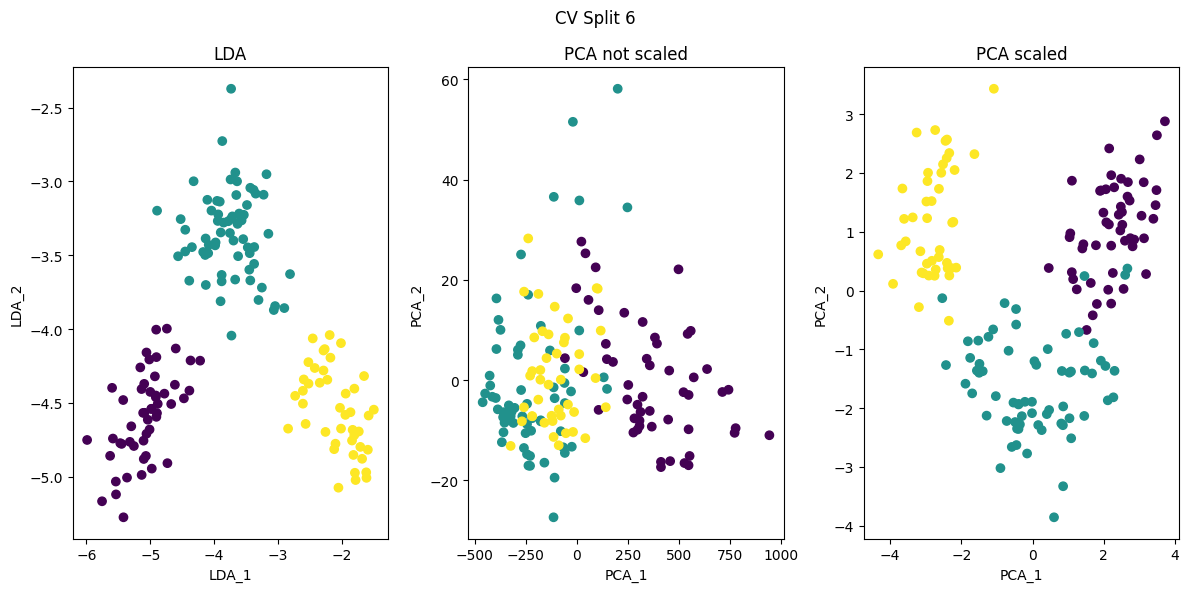

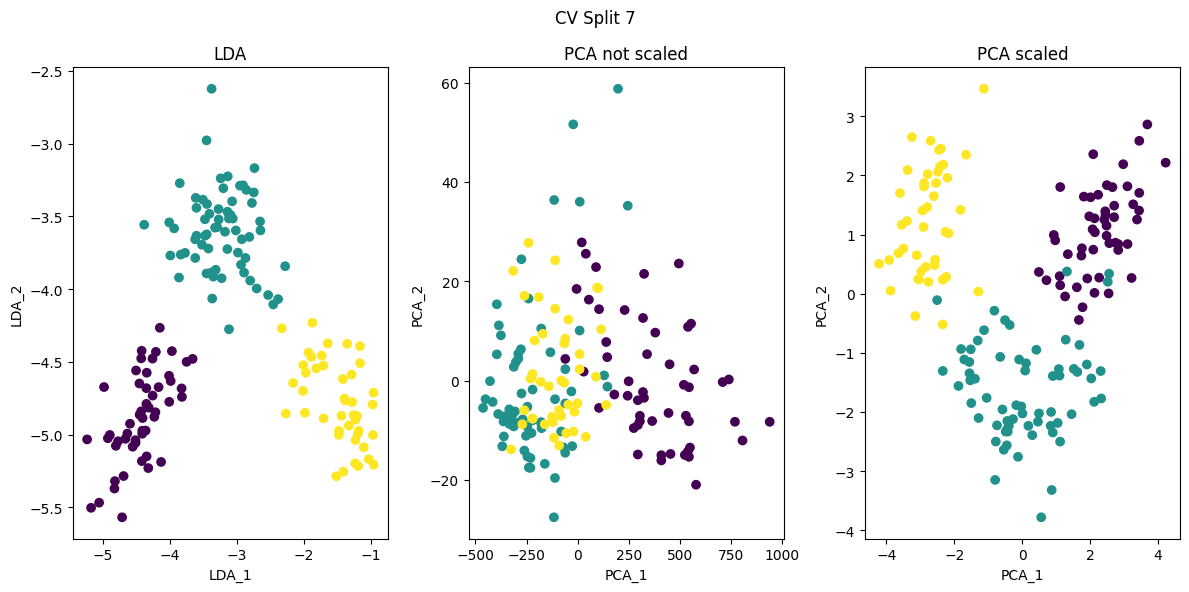

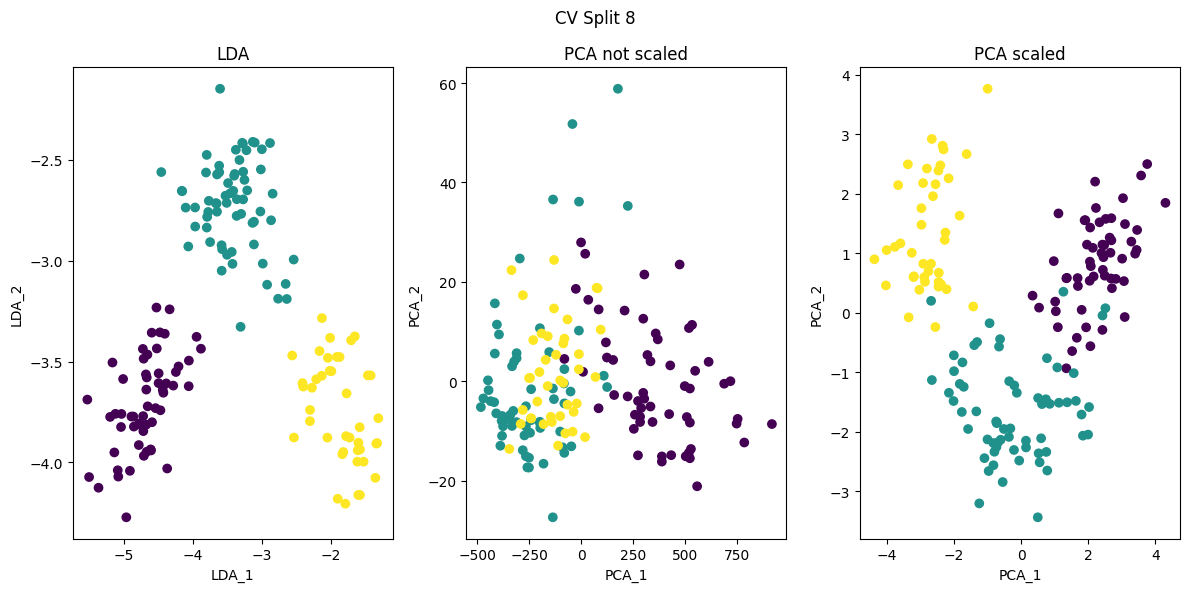

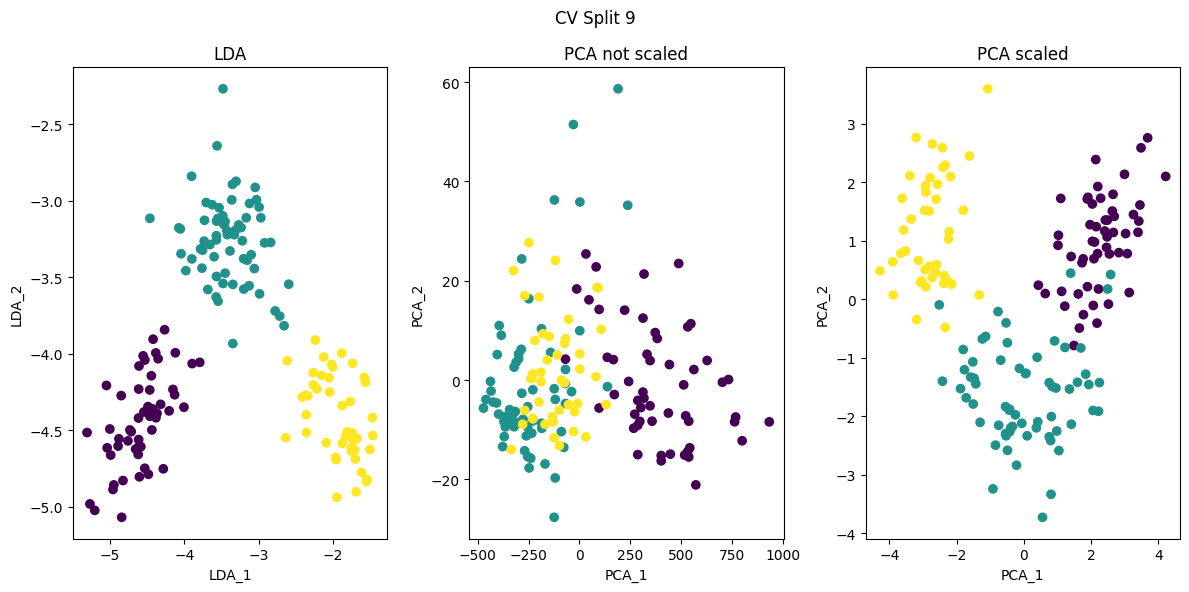

In [63]:
# 1. read the data
df = pd.read_csv("wine.csv", header=None)
labels = df.iloc[:, 0].values
data = df.iloc[:, 1:].values
n_classes = len(np.unique(labels))

# 2. compute LDA and return corresponding eigenvectors
eigen_lda = LDA(data, labels, plot_title="All data")

# 3. project data on LDA defined space
# TODO: replace with your own solution
projected_data = data @ eigen_lda[:, :3]

# 4. find centroids and assign data to them (classify)
centroids = compute_centroids(projected_data, labels)
predicted_labels = classify(data, eigen_lda, centroids, np.full(n_classes, 1. / n_classes))

# 5. evaluate the algorithm
# ACC
print("accuracy:", np.mean(predicted_labels == labels))

# cross-validation
acc_lda = crossvalidation_lda(data, labels, n_folds=10)
print("Cross validation mean: ", acc_lda)

**Discuss your results.** Compare your LDA performance with PCA, explain how the two methods differ theoretically. What else would you conclude from your experiment.

### Comparison
- In the non-scaled PCA plot, the data points from different classes overlap significantly, indicating that the directions of maximum variance do not align well with class boundaries.
- After scaling the features, the PCA projection shows improved separation; however, some overlap between classes still remains.
- In contrast, the LDA projection achieves a clear separation between classes with minimal to no overlap.

### PCA vs LDA theorically
- The goal of PCA is to find directions of maximum variance in the data. In contrast, the goal of LDA is to find directions of maximum class separability
- PCA is unsupervised method that does not use class labels. In contrast, the LDA is supervised method that uses class lables.
- The number of components in PCA is limited by the number of features. In contrast, in LDA it is limited by one less than the number of classes.
- PCA is primarily used for dimensionality reduction. In contrast, LDA serves both dimensionality reduction and classification purposes.

### From experiment
- The PCA projection shows that the classes overlap substantially, meaning that variance in the dataset does not correspond directly to class-discriminative directions.
- In contrast, the LDA projection produces well-separated clusters for each class, demonstrating that it captures class information much more effectively.

## Feedback
Was some part of the notebook unclear, would any topic need more attention during the tutorials? 
If you want to leave us feedback on the assignment, we would be happy to hear it. 
Here is your space: